In [1]:
from __future__ import division
from scipy.optimize import curve_fit
from pylab import *
%matplotlib inline

For a fundamental Gaussian beam the curvature at position Z is  $$\frac{1}{R(z)} = \frac{z}{z^2+z^2_R}$$
Rayleigh range is $$Z_R = \frac{\pi \omega^2_0 n}{\lambda}$$ where $\omega_0$ is the radius at the waist
At position z along the beam, the spot size is $$\omega(z) = \omega_0 \sqrt{1+(\frac{z}{z_R})^2}$$

#### Constant Parameters

All dimensions are scaled to millimeters (keep in mind when specifying waists and focal length)

Make sure you put in your wavelength here!)

In [2]:
mm=1e-3
lam=852e-9/mm #wavelength

#### Basics functions

Function for propegation of Gaussian beam by ABCD matrix method.  See Yariv Quanutum Electronics, or Siegmann Lasers for textbook treatment

In [3]:
def zr(waist):
    #rayleigh range
    return pi*waist**2/lam
def waistz0(lam,z0):
    return np.sqrt(lam*z0/np.pi)
def waistz(z,z0,w0):
    #beam waist as function of z
    return w0*sqrt(1+((z-z0)/zr(w0))**2)
def radiusz(z,z0,w0):
    #beam radius of curvature as function of z
    return (z-z0)*(1+((z-z0)/zr(w0))**2)
def q0(w0):
    #q parameter at waist
    return 1j*pi*w0**2/lam
def wfromq(q):
    #convert q back to waist values
    return sqrt(-1*lam/(pi*imag(1/q)))
def propd(q,d):
    #propegaction of q by distance d
    return q+d
def lensf(q,f):
    #action of lens of focal lens f on q
    return q/(-q/f+1)
def qz(z,z0,w0):
    #q parameter at z given w0 at z0
    return propd(q0(w0),z-z0)

#### Find waist from two point measurement

Assume we measure the waist $w_1$ at $z=z_1=0$ and $w_2$ at $z=z_2$, find the location and value of the waist, $z_0,w_0$ (for both x and y)

In [4]:
def findwaist(w1,w2,z2):
    zdata=array([0,z2])
    wdata=array([w1,w2])
    #curvefit to waist function using p0=[z0,w0] as initial parameters
    if w1>w2: #if focusing, using second waist as initial parameters
        [z0,w0]=[2*z2,w2/2.]
    else: #if diverging, use first waist
        [z0,w0]=[-z2,w1/2.]
    popt, pcov = curve_fit(waistz,zdata,wdata,p0=[z0,w0])
    return popt #return fit paramers [z0,w0]

x: z0=-1260.31 mm and w0=0.327 mm
y: z0=-1260.30 mm and w0=0.318 mm


(-1000.0, 5000.0)

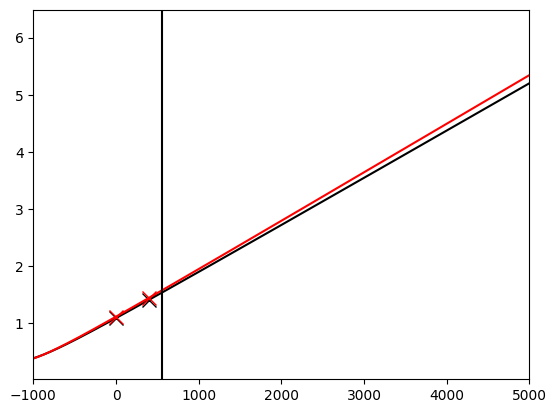

In [97]:
#measured values: (assumes z1=0)

#x
[xw1,xw2,xz2]=[1.095,1.415,16*25] #measured values
[xz0,xw0] = findwaist(xw1,xw2,xz2)
print("x: z0=%0.2f mm and w0=%0.3f mm" %(xz0,xw0))
#y
[yw1,yw2,yz2]=[1.120,1.450,16*25]  #measured values
[yz0,yw0] = findwaist(yw1,yw2,yz2)
print("y: z0=%0.2f mm and w0=%0.3f mm" %(yz0,yw0))
#[.504,.598,475]


max_dist = 6000 #total propegaction distance in mm
Nsteps = 5000
zlist = linspace(-max_dist,max_dist,Nsteps)
plot(0,xw1,'kx',markersize=10)
plot(xz2,xw2,'kx',markersize=10)
plot(xz0,xw0,'ko')

plot(zlist,waistz(zlist,xz0,xw0),'k')
plot(0,yw1,'rx',markersize=10)
plot(yz2,yw2,'rx',markersize=10)
plot(yz0,yw0,'ro')
plot(zlist,waistz(zlist,yz0,yw0),'r')
plt.axvline(x=22*25.4,color='k')
plt.xlim(-1000,5000)

# xz0 = 0
# xw0 = 0.65
# yz0 = 0
# yw0 = 0.65

#### Set up beam propegation:

In [98]:
#inital q parameters at z=0 for x and y (using waist locations determerined above)
qx0 = qz(0,xz0,xw0)
qy0 = qz(0,yz0,yw0)
# qx0 = q0(0.8)
# qy0 = q0(0.8)
print(qx0)
print(qy0)

max_dist = 1400 #total propegaction distance in mm
Nsteps = 500
zlist = linspace(0,max_dist,Nsteps)
stepsize = zlist[1] - zlist[0]
q = 1j*zeros((2,Nsteps)) #top row is for x and bottom row is y
q[:,0] = [qx0,qy0] #set inital parameters


(1260.305897054901+394.45716425306233j)
(1260.2982672399248+373.5719124669994j)


#### Simulation for using a single lens to collimate the beam

0.6227216638708083
0.6310672322731289


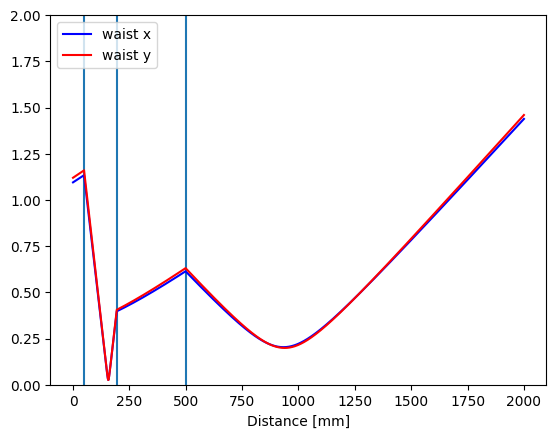

In [115]:
max_dist = 2000 #total propegaction distance in mm
Nsteps = 2000
zlist = linspace(0,max_dist,Nsteps)
stepsize = zlist[1] - zlist[0]
q = 1j*zeros((2,Nsteps)) #top row is for x and bottom row is y
q[:,0] = [qx0,qy0] #set inital parameters

#denfine lenses [z,fx,fy]
finf=10e6 #effective infinite focal length for cylindiral lenses, using 'inf' causes an error

f1=100.
f2= 40.
f3 = 300
p0 = 50
p1 = 195
p2= 500
lens1=[p0,f1,f1]
lens2=[p1,f2,f2]
lens3=[p2,f3,f3]

lenses=array([lens1,lens2])
lenses=array([lens1,lens2,lens3])
#lenses=array([lens1])


for i,z in enumerate(zlist[1:]):
    for j in range(len(lenses[:,0])): #loop over lenses
        if abs(z-lenses[j,0])<stepsize/2: #if less than half step size from lens location, apply to q
            q[0,i]=lensf(q[0,i],lenses[j,1])
            q[1,i]=lensf(q[1,i],lenses[j,2])
            plt.axvline(x=lenses[j,0])
    q[0,i+1]=propd(q[0,i],stepsize)
    q[1,i+1]=propd(q[1,i],stepsize)
    
wx=wfromq(q[0,:])
wy=wfromq(q[1,:])

plot(zlist,wx,'b',label='waist x',)
plot(zlist,wy,'r',label='waist y')
xlabel('Distance [mm]')
legend(loc=2)
ylim(0,2)


print(wx[0:2000].mean())
print(wy[0:2000].mean())

#### Calculation for using a single lens to get mode matching

For a fundamental Gaussian beam the curvature at position Z is  $$\frac{1}{R(z)} = \frac{z}{z^2+z^2_R}$$
Rayleigh range is $$Z_R = \frac{\pi \omega^2_0 n}{\lambda}$$ where $\omega_0$ is the radius at the waist
At position z along the beam, the spot size is $$\omega(z) = \omega_0 \sqrt{1+(\frac{z}{z_R})^2}$$

For our new cavity, $R1 = 1000, R2 = 1000, L = 268$

To get mode matching, the new beam waist needs to be at mirror 1 and radius of curvature at mirror 2 needs to be R2.

So we take z as the half length of cavity, means $z = 134$, then from eq1 we have 

In [13]:
z = 134
R2 = 1000
zR = np.sqrt(z*R2-z**2)
print("the Rayleigh range is:",zR,"mm")

the Rayleigh range is: 340.6523154185217 mm


Then from eq2 we can calculate the new beam waist

In [14]:

w0_new = np.sqrt(zR * lam/ np.pi)
wm = w0_new * np.sqrt(1+(z/zR)**2)
print("the waist at flat mirror is:", w0_new, "mm")
print("the waist at curve mirror is:", wm, "mm")

the waist at flat mirror is: 0.30394887034869117 mm
the waist at curve mirror is: 0.32661910740740363 mm


Now assume z is the focus length of the spherical lens and input waist is the collimated waist $\omega = 0.64$, from eq3 we can get calculate z:

In [20]:
#w0 = np.linspace(0.2,1,1000)        # beam waist after collimating
w0 = 0.57
f_len = zR*np.sqrt((w0/w0_new)**2-1)
#plot(w0,f_len,'-')
print("The focus length of the lens is:", f_len, "mm" )

The focus length of the lens is: 540.4261779743823 mm


In [11]:
R = 0.55
G10 = 4.75e3
F = 1e6/(1e6+50)
P = 0.9e-3 
V = R * G10 * F * P 
print("output voltage is:", V,"V")

output voltage is: 2.351132443377831 V


In [12]:
0.4e-3/(1-0.9997) 

1.3333333333334803